# Main goal: 
Here, we aim to integrate differential analysis results (treated vs. non-treated) toward making a final list of genes which are significantly methylated, expressed and stabilized.

=> table of these genes with all logFCs, pvalues and screening scores.

In [15]:
import sys 
import pandas as pd 
import numpy as np
from matplotlib.pyplot import subplots
from itertools import chain, product
from venn import venn 

sys.path.append('../')

from util import *

### Load data
Comparing treated with Decitabine vs. non-treated:
- **$\Delta$RNA methylation**  (hl60 cell line)
- **$\Delta$Translational efficiency** (hl60 cell line)
- **$\Delta$RNA expression** (For all 6 AML cell lines)
- **$\Delta$RNA stability** (For all 6 AML cell lines)
- **$\Delta$Phenotype, CRISPRi-screen $\rho$(rho) score** (hl60 and molm13 cell lines) 

In [16]:
comps = load_data(comparisons=True)

In [17]:
scrns = load_data(screens=True)

Find top genes across all cell lines and high throughput experiments:


In [18]:
Top = {}

Top['Mtyl'] = set_Top_Mtyl(1,0.01,comps)
Top['Rho'] = set_Top_Rho(0.1,1,'hl60',scrns)

Top['TE']   = set_Top_TE  (0,0.05,comps)
Top['Exp']  = set_Top_Exp (0,0.05, 'hl60',comps)
# Top['Stbl'] = set_Top_Stbl(0,0.05, 'hl60',comps)

Subset Top Mtyl data frame:
up:  1704
down: 1210
(fc_thr=1, pv_thr=0.01)
Subset Top Rho data frame:
up:  434
down: 536
(sc_thr=0.1, pv_thr=1) in hl60 cell line
Subset Top TE data frame:
up:  40
down: 11
(te_thr=0, fdr_thr=0.05)
Subset Top Exp data frame:
up:  3424
down: 3043
(fc_thr=0, pv_thr=0.05) in hl60 cell line


### Intersection of all genes across different datasets

- https://pypi.org/project/venn/

Select top gene names 

In [19]:
Exp_up = Top['Exp']['up'].index.tolist()
# Stbl_up = Top['Stbl']['up'].index.tolist()
Rho_up = Top['Rho']['up'].index.tolist()
TE_up = Top['TE']['up'].gene_name.tolist()
Hyper_m6A = Top['Mtyl']['up'].gene_name.tolist()

Exp_down = Top['Exp']['down'].index.tolist()
# Stbl_down = Top['Stbl']['down'].index.tolist()
Rho_down = Top['Rho']['down'].index.tolist()
TE_down = Top['TE']['down'].gene_name.tolist()
Hypo_m6A = Top['Mtyl']['down'].gene_name.tolist()

In [20]:
def iter_by_two(input1,input2,input3):
    # inputs are variable names 
    # it will give 8 combinations 
    out = []
    for comb in list(product(input1,input2,input3)):
        a,b,c = comb
        out.append([a,b,c])
    return out 

def plot_combinations(add_stbl=False):
    studies = iter_by_two(['Exp_up', 'Exp_down'],['Rho_up', 'Rho_down'],['Hyper_m6A', 'Hypo_m6A'])
#     if add_stbl: studies = [[s[0].replace('Exp','Stbl'),s[0],s[1],s[2]] for s in studies]

    _, top_axs = subplots(ncols=4, nrows=1, figsize=(18, 8),dpi=500)
    _, bot_axs = subplots(ncols=4, nrows=1, figsize=(18, 8),dpi=500)
    # cmaps = ["cool", list("rgb"), "plasma", "viridis", "Set1"]
    # letters = iter(ascii_uppercase)

    for std,ax in zip(studies,chain(top_axs, bot_axs)):
        data = {}
        data = dict([[a,set(eval(a))] for a in std])
        venn(data,fontsize=10,legend_loc="upper left", ax=ax)

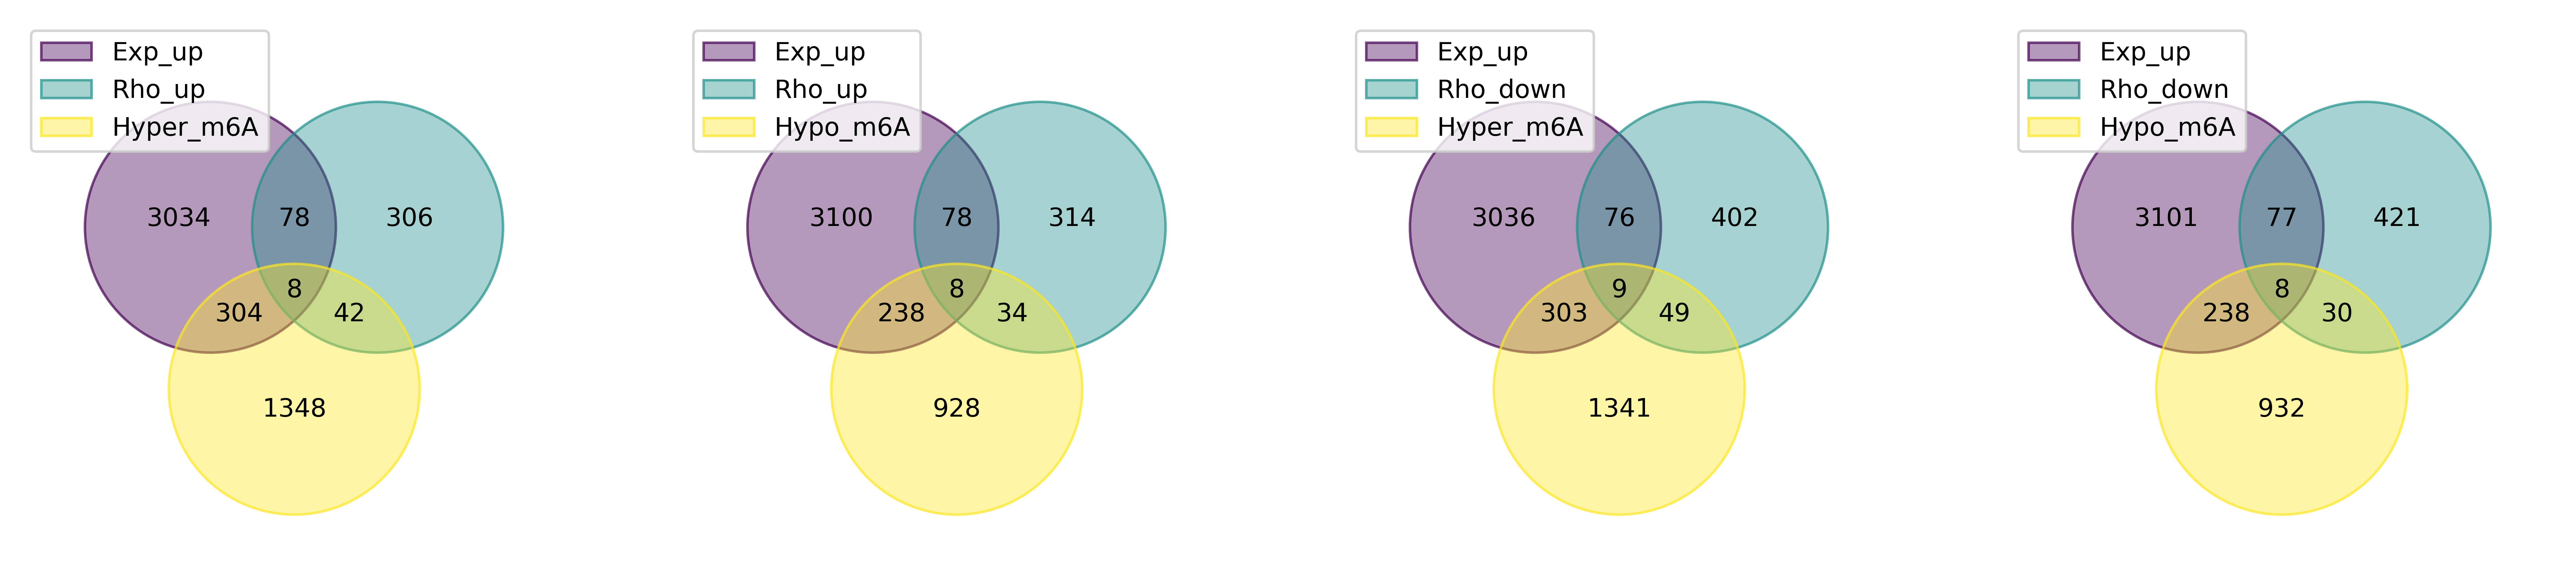

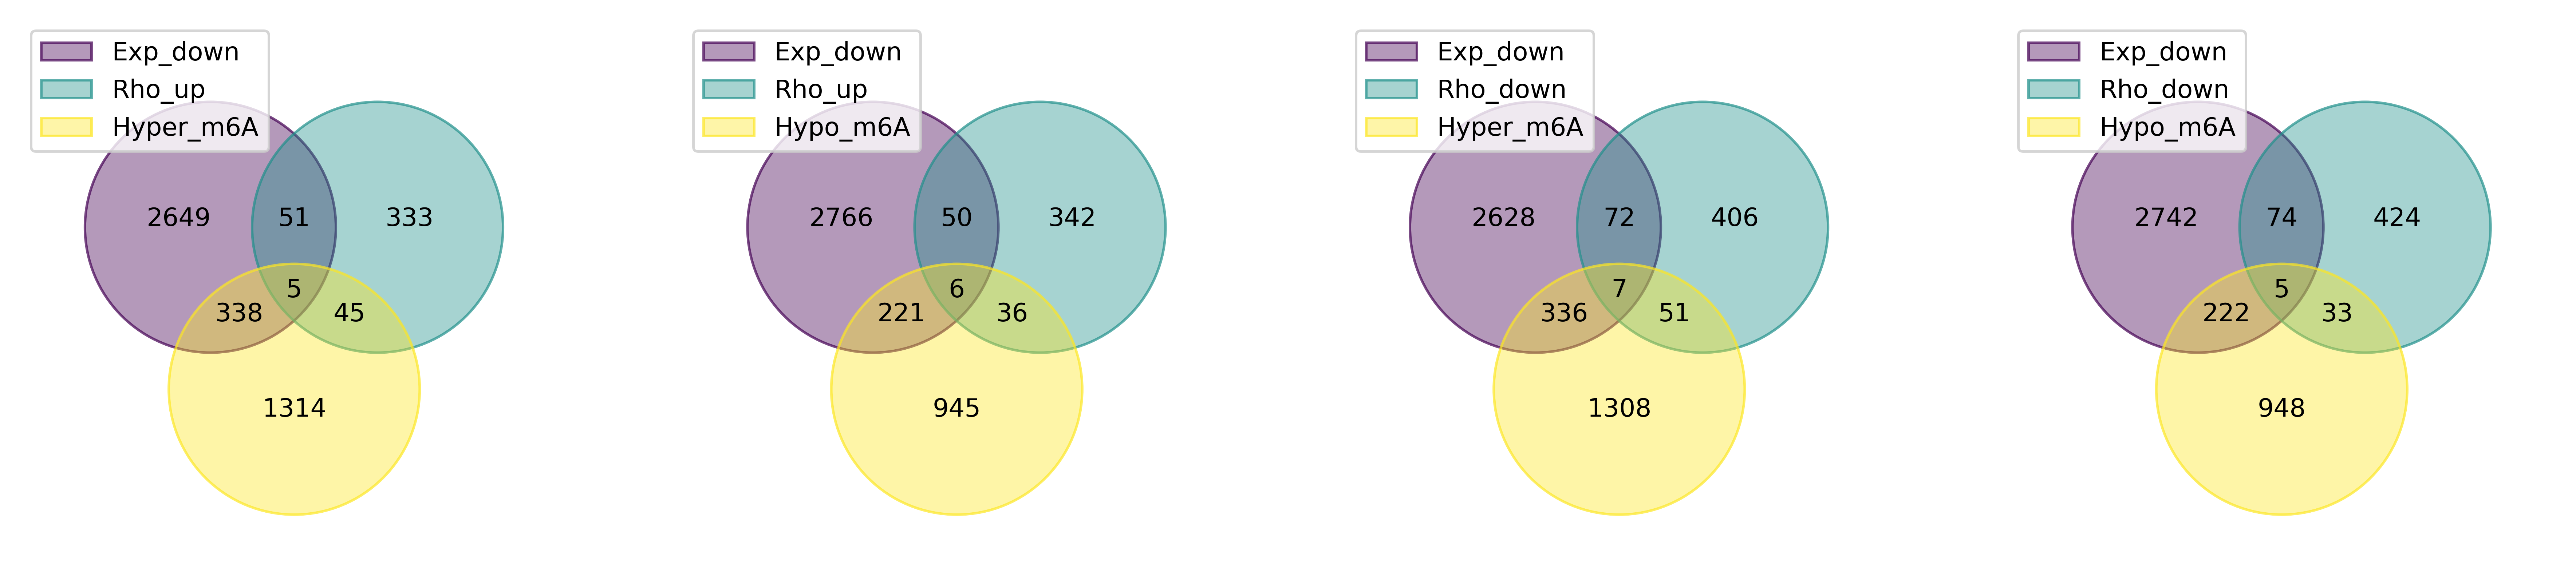

In [21]:
plot_combinations()

# Final merged table

In [22]:
# comps = load_data(comparisons=True)
# scrns = load_data(screens=True)

In [23]:
def get_intersect_df(intersect_genes, data, key=None):
    # get intersects 
    # Note: change intersect_genes based on the biological question
    if key is not None: 
        df = data[key]
    else: 
        df = data

    out = df.iloc[[i for i, g in enumerate (df.gene_name) if g in list(intersect_genes)],]

    return out


def filter_genes(genes,df):
    genes = [gene for gene in genes if gene in df.index.tolist()]
    out = df.loc[genes,:]
    return out


def make_comp_final_table(genes,data):
    exp_df = merge_exp_data(data=data)
#     stbl_df = merge_stbl_data(data=data)
    
    E = get_intersect_df(genes, exp_df)
#     S = get_intersect_df(genes, stbl_df)
    T = get_intersect_df(genes, data['hl60'],'delta_te')

    out = pd.DataFrame(index=genes)

    out = pd.concat([
        out,
        # RNA Expression
        E.reset_index(drop=True).set_index('gene_name').add_prefix('Exp.'),
#         # RNA Stability 
#         S.reset_index(drop=True).set_index('gene_name').add_prefix('Stbl.'),
        # Translational Efficiency
        T.reset_index(drop=True).set_index('gene_name').add_prefix('TE.'),
    ],axis=1)
    
    out = out.round(3)
    return out

def make_scrn_final_table(genes,data):
    
    R = merge_screen_data('hl60','rho', data=data)
    R = filter_genes(genes,R)
    G = merge_screen_data('hl60','gamma', data=data)
    G = filter_genes(genes,G)
    
    out = pd.DataFrame(index=genes)
    
    out = pd.concat([
        out,
        # CRISPR Screen Rho score
        R,
        # CRISPR Screen Gamma score
        G,
    ],axis=1)
    
    out = out.round(3)
    return out

def make_mtyl_final_table(genes):
    mtyl_bed12 = pd.read_csv('../meRIP-seq/hl60_delta_mtyl_table.txt',sep='\t').rename(columns={'name':'gene_name'})
    M = get_intersect_df(genes,mtyl_bed12)

    # RNA Methylation 
    out = M.reset_index(drop=True)
    return out 

In [42]:
def write_excel(s1,s2,s3,s4):
    
    name = f'Rho_{s1} & Exp_{s2} & {s4}_m6A'

    genes = list(set(eval(f'Rho_{s1}')).intersection(eval(f'Exp_{s2}'),eval(f'{s4}_m6A')) )
        
    print (name)
    print (genes)
    print ('\n\n')
#     writer = pd.ExcelWriter(f'intersectional-genes/{name}.xlsx', engine='xlsxwriter')
    
#     make_mtyl_final_table(genes).to_excel(writer, sheet_name='Methylation',index=False)
#     make_comp_final_table(genes,data=comps).to_excel(writer, sheet_name='Comparisons')
#     make_scrn_final_table(genes,data=scrns).to_excel(writer, sheet_name='CRISPRi-screens')
    
#     writer.save()
    

In [35]:
for i,j,k in iter_by_two(['up', 'down'],['up', 'down'],['Hyper', 'Hypo']):
    write_excel(i,j,j,k)

Rho_up & Exp_up & Hyper_m6A
['MRPL17', 'RBFA', 'POLR1C', 'KLF16', 'PREB', 'TTI1', 'EIF4G1', 'GEMIN4']



Rho_up & Exp_up & Hypo_m6A
['ELP5', 'KLF16', 'FDFT1', 'MECR', 'MIOS', 'TTI1', 'NUDCD3', 'ZNF787']



Rho_up & Exp_down & Hyper_m6A
['MBD6', 'UHRF1', 'MAP1S', 'DDX19A', 'CEP152']



Rho_up & Exp_down & Hypo_m6A
['SHOC2', 'DENND1A', 'ZNF830', 'ZC3H13', 'MANBA', 'PTCD1']



Rho_down & Exp_up & Hyper_m6A
['DDX6', 'PPRC1', 'ZNF514', 'CCP110', 'SQLE', 'NSUN2', 'RBM14-RBM4', 'DHODH', 'MTF1']



Rho_down & Exp_up & Hypo_m6A
['ZBTB9', 'GPR183', 'PPRC1', 'ZNF514', 'UCK2', 'ACBD3', 'ELAVL1', 'MTF1']



Rho_down & Exp_down & Hyper_m6A
['MCL1', 'TTC14', 'CYLD', 'APLP2', 'UBXN7', 'PGD', 'RGS19']



Rho_down & Exp_down & Hypo_m6A
['FPR2', 'SGMS1', 'CFLAR', 'SLC44A2', 'NFKBIA']





In [39]:
!zip intersectional-genes/xlsx.zip intersectional-genes/*xlsx

  adding: intersectional-genes/Rho_down & Exp_down & Hyper_m6A.xlsx (deflated 9%)
  adding: intersectional-genes/Rho_down & Exp_down & Hypo_m6A.xlsx (deflated 10%)
  adding: intersectional-genes/Rho_down & Exp_up & Hyper_m6A.xlsx (deflated 8%)
  adding: intersectional-genes/Rho_down & Exp_up & Hypo_m6A.xlsx (deflated 9%)
  adding: intersectional-genes/Rho_up & Exp_down & Hyper_m6A.xlsx (deflated 10%)
  adding: intersectional-genes/Rho_up & Exp_down & Hypo_m6A.xlsx (deflated 9%)
  adding: intersectional-genes/Rho_up & Exp_up & Hyper_m6A.xlsx (deflated 9%)
  adding: intersectional-genes/Rho_up & Exp_up & Hypo_m6A.xlsx (deflated 9%)


In [54]:
all_genes = []

for i,j,k in iter_by_two(['up', 'down'],['up', 'down'],['Hyper', 'Hypo']):
    
    name = f'Rho_{i} & Exp_{j} & {k}_m6A'

    genes = list(set(eval(f'Rho_{i}')).intersection(eval(f'Exp_{j}'),eval(f'{k}_m6A')) )
        
    all_genes = all_genes + genes


In [62]:
comps['hl60']['delta_exp'].set_index('gene_name').loc[[    
    "MCL1",
    "TTC14",
    "CYLD",
    "APLP2",
    "UBXN7",
    "PGD",
    "RGS19",
    "FPR2",
    "SGMS1",
    "CFLAR",
    "SLC44A2",
    "NFKBIA",
    "DDX6",
    "PPRC1",
    "ZNF514",
    "CCP110",
    "SQLE",
    "NSUN2",
    "RBM14-RBM4",
    "DHODH",
    "MTF1",
    "ZBTB9",
    "GPR183",
    "PPRC1",
    "ZNF514",
    "UCK2",
    "ACBD3",
    "ELAVL1",
    "MTF1",
    "MBD6",
    "UHRF1",
    "MAP1S",
    "DDX19A",
    "CEP152",
    "SHOC2",
    "DENND1A",
    "ZNF830",
    "ZC3H13",
    "MANBA",
    "PTCD1",
    "MRPL17",
    "RBFA",
    "POLR1C",
    "KLF16",
    "PREB",
    "TTI1",
    "EIF4G1",
    "GEMIN4",
    "ELP5",
    "KLF16",
    "FDFT1",
    "MECR",
    "MIOS",
    "TTI1",
    "NUDCD3",
    "ZNF787"
]
].to_csv('temp.txt')

## _MTF1_

In [18]:
comps['hl60']['delta_exp'].loc[comps['hl60']['delta_exp']['gene_name'] == 'MTF1']

,gene_id,gene_name,baseMean,log2FC_6h,pval_6h,log2FC_72h,pval_72h,log2FC_120h,pval_120h
13814,ENSG00000188786.10,MTF1,469.977468,0.358417,0.000008,0.086559,0.000008,-0.157071,0.000008


In [5]:
# for i,j,k in iter_by_two(['up', 'down'],['up', 'down'],['Hyper', 'Hypo']):
#     write_excel(i,j,j,k)